## Colab Setup

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install Keras==2.1

In [3]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
backports.tempfile            1.0            
backports.weakref             1.0.post1      
beautifulsoup4                4.6.

In [4]:
# mounting and connecting with drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import warnings 
warnings.filterwarnings("ignore")

In [6]:
# importing libraries
import os
import gc
import sys
import math
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from IPython.display import clear_output

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

import tensorflow as tf

In [7]:
# setting up path directory
DATA_DIR = Path('/content/drive/My Drive/myntra /')
ROOT_DIR = Path('/content/')
IMAGE_DIR = Path('/content/drive/My Drive/myntra /Train large')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks

NUM_CATS = 46
IMAGE_SIZE = 512

## Setting up Mask RCNN

In [8]:
os.chdir("/content")
!rm -rf Mask_RCNN 

# import matterport Mask-RCNN implementation
!git clone https://www.github.com/matterport/Mask_RCNN.git;
os.chdir('Mask_RCNN')
!ls
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.24 MiB | 22.17 MiB/s, done.
Resolving deltas: 100% (559/559), done.
assets	LICENSE      mrcnn	requirements.txt  setup.cfg
images	MANIFEST.in  README.md	samples		  setup.py


In [9]:
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [10]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [11]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
#     STEPS_PER_EPOCH = 10
#     VALIDATION_STEPS = 2
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [12]:
with open(DATA_DIR/"labels.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
attribute_names = [x['name'] for x in label_descriptions['attributes']]

In [13]:
print(len(label_names))
print(len(attribute_names))

46
92


In [14]:
label_names

['shirt, blouse',
 'top, t-shirt, sweatshirt',
 'sweater',
 'cardigan',
 'jacket',
 'vest',
 'pants',
 'shorts',
 'skirt',
 'coat',
 'dress',
 'jumpsuit',
 'cape',
 'glasses',
 'hat',
 'headband, head covering, hair accessory',
 'tie',
 'glove',
 'watch',
 'belt',
 'leg warmer',
 'tights, stockings',
 'sock',
 'shoe',
 'bag, wallet',
 'scarf',
 'umbrella',
 'hood',
 'collar',
 'lapel',
 'epaulette',
 'sleeve',
 'pocket',
 'neckline',
 'buckle',
 'zipper',
 'applique',
 'bead',
 'bow',
 'flower',
 'fringe',
 'ribbon',
 'rivet',
 'ruffle',
 'sequin',
 'tassel']

In [15]:
attribute_names

['above-the-hip (length)',
 'hip (length)',
 'micro (length)',
 'mini (length)',
 'above-the-knee (length)',
 'knee (length)',
 'below the knee (length)',
 'midi',
 'maxi (length)',
 'floor (length)',
 'single breasted',
 'double breasted',
 'lace up',
 'wrapping',
 'zip-up',
 'fly (opening)',
 'buckled (opening)',
 'toggled (opening)',
 'no opening',
 'asymmetrical',
 'symmetrical',
 'peplum',
 'circle',
 'flare',
 'fit and flare',
 'trumpet',
 'mermaid',
 'balloon',
 'bell',
 'bell bottom',
 'bootcut',
 'peg',
 'pencil',
 'straight',
 'a-line',
 'tent',
 'baggy',
 'wide leg',
 'high low',
 'curved (fit)',
 'tight (fit)',
 'regular (fit)',
 'loose (fit)',
 'oversized',
 'burnout',
 'distressed',
 'washed',
 'embossed',
 'frayed',
 'printed',
 'ruched',
 'quilted',
 'pleat',
 'gathering',
 'smocking',
 'tiered',
 'cutout',
 'slit',
 'perforated',
 'lining',
 'no special manufacturing technique',
 'plain (pattern)',
 'abstract',
 'cartoon',
 'letters, numbers',
 'camouflage',
 'check',


In [16]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

print('le_segment_df',len(segment_df))
print(segment_df.head())
multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

le_segment_df 331213
                                ImageId  ... ClassId
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...       6
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...       0
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...      28
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...      31
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg  ...      32

[5 rows x 5 columns]
Segments that have attributes: 3.47%


In [17]:
segment_df.columns

Index(['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId'], dtype='object')

In [18]:
# segment_df['CategoryId'] = segment_df['Class']
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]
segment_df['AttributeId'] = segment_df['ClassId'].str.split('_').str[1:]

print("Total segments: ", len(segment_df))

print('max_id:',max(list(map(lambda x:int(x),segment_df['CategoryId'] ))))
segment_df.head()

Total segments:  331213
max_id: 45


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId,AttributeId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6,[]
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0,[]
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28,[]
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31,[]
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32,[]


In [19]:
def show_img(IMG_FILE):
    I = cv2.imread("/content/drive/My Drive/myntra /Train large/" + IMG_FILE, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = cv2.resize(I, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    plt.imshow(I) 
    
def complete_make_mask(data,IMG_FILE):
    mask_list, cat_list = [], []
    df = data[data.ImageId == IMG_FILE].reset_index(drop = True)
    H = df.iloc[0,2]
    W = df.iloc[0,3]
    
    print("Correct Category :", sorted(set((list(df.CategoryId)))))
    # 1d mask 
    
    for line in df[['EncodedPixels','CategoryId']].iterrows():
        # 1d mask 
        mask = np.full(H*W,dtype='int',fill_value = -1)
        
        EncodedPixels = line[1][0]
        Category = line[1][1]
        
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = Category
        mask = mask.reshape(W,H).T
#         print(Category, mask.shape)
        mask_list+=[mask]
        cat_list+=[Category]
    
#     print("Output :",sorted(set(list(mask))))
#     print('mask:\n',set(list(mask)))
#     mask = mask.reshape(W,H).T
    #rle
#     return mask
    return cat_list, mask_list

Correct Category : ['29', '31', '9']
Correct Category : ['1', '18', '23', '24', '28', '31', '33', '35', '4', '6']
Correct Category : ['10', '23', '31', '33']


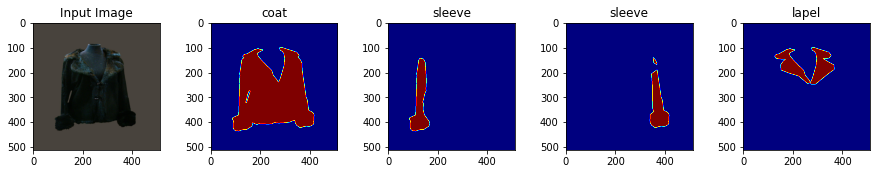

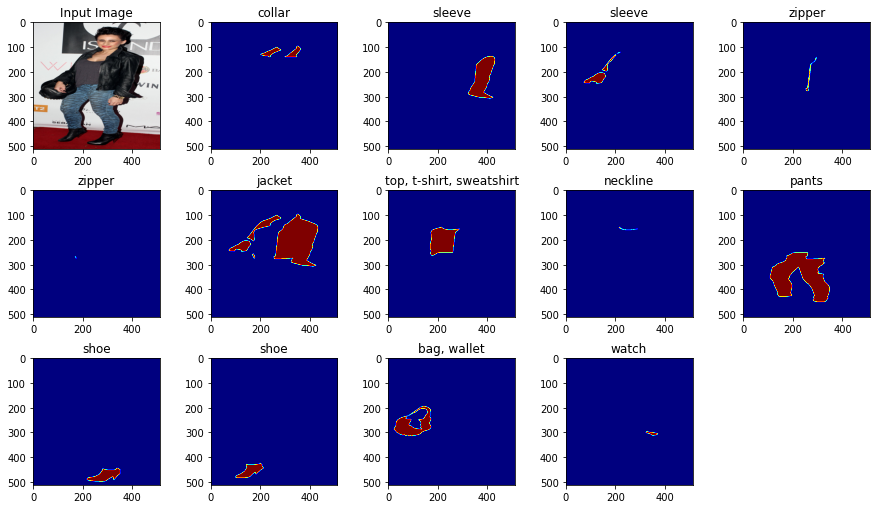

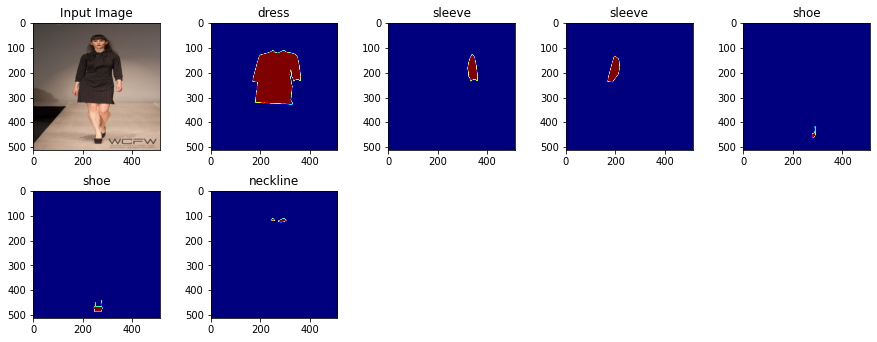

In [20]:
img_list = os.listdir(IMAGE_DIR)
for k in img_list[:3]:
    cat_list1, mask_list1 = complete_make_mask(segment_df, k)
    plt.figure(figsize=[15,15])
    plt.subplot(3,5,1)
    show_img(k)
    plt.title('Input Image')
    i=1
    for mask, cat in zip(mask_list1, cat_list1):
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        plt.subplot(3,5,i+1)
        i+=1
        plt.imshow(mask,cmap='jet')
        plt.title(label_names[int(cat)])
    plt.subplots_adjust(wspace=0.4, hspace=-0.65)

In [21]:
seg_att_df = segment_df[[len(x)>0 for x in segment_df['AttributeId']]].reset_index(drop=['index'])
len(seg_att_df)

11499

In [22]:
seg_att_df.iloc[30:50]

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId,AttributeId
30,0091ae902cb738e4ca06038c2654fa00.jpg,546345 59 548136 69 549926 80 551717 91 553507...,1800,1200,4_0_14_20_42_59_65_91,4,"[0, 14, 20, 42, 59, 65, 91]"
31,0091ae902cb738e4ca06038c2654fa00.jpg,751673 39 753408 116 755160 176 756929 219 758...,1800,1200,9_9_20_41_59_61_91,9,"[9, 20, 41, 59, 61, 91]"
32,0091ae902cb738e4ca06038c2654fa00.jpg,857249 10 859049 31 860849 42 862649 43 864449...,1800,1200,1_0_20_40_60_61,1,"[0, 20, 40, 60, 61]"
33,0091ae902cb738e4ca06038c2654fa00.jpg,897828 33 899595 69 901388 80 903182 90 904975...,1800,1200,6_8_15_20_31_41_46_61,6,"[8, 15, 20, 31, 41, 46, 61]"
34,009447b79fce7da1ee19a54401517cde.jpg,25048107 6 25053398 19 25058690 32 25063981 45...,5304,7952,1_0_20_40_60_61_88,1,"[0, 20, 40, 60, 61, 88]"
35,009447b79fce7da1ee19a54401517cde.jpg,23488547 6 23493844 17 23499140 29 23504436 40...,5304,7952,5_0_14_20_41_46_61_91,5,"[0, 14, 20, 41, 46, 61, 91]"
36,009447b79fce7da1ee19a54401517cde.jpg,23802163 9 23807451 27 23812746 37 23818049 40...,5304,7952,7_2_15_20_41_46_61_88,7,"[2, 15, 20, 41, 46, 61, 88]"
37,009d3fad34c4184fc93f3db4427bbf7a.jpg,5177175 57 5182030 171 5186934 236 5191885 253...,4962,3308,10_3_10_20_33_60_61_91,10,"[3, 10, 20, 33, 60, 61, 91]"
38,009f88701b43c02d0e9ca6464df6adba.jpg,6093938 1 6097000 3 6100061 6 6103122 9 610618...,3063,4621,10_3_14_20_24_52_69_87,10,"[3, 14, 20, 24, 52, 69, 87]"
39,00c613d7ce33173d59b8661e2978049d.jpg,515923 3 517511 10 519100 16 520688 22 522276 ...,1594,1000,10_6_14_20_32_61_87,10,"[6, 14, 20, 32, 61, 87]"


In [23]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

# image_df = image_df[:10]
# image_df = image_df.iloc[:10]
print("Total images: ", len(image_df))
image_df.head()

Total images:  45195


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [24]:
def resize_image(image_path):
  print(image_path)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
  return img

In [25]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'Train large'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

/content/drive/My Drive/myntra /Train large/0004467156e47b0eb6de4aa6479cbd15.jpg
mask_shape: (512, 512, 5)
img_shape: (512, 512, 3)
[11 34 32 32 16]
['BG', 'shirt', 'top', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights', 'sock', 'shoe', 'bag', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
47


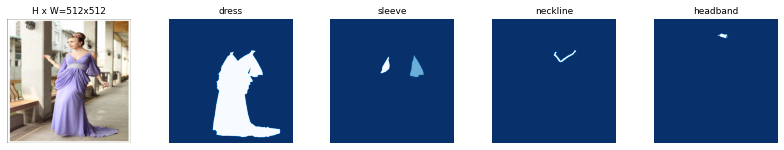

In [26]:
dataset = FashionDataset(image_df)
dataset.prepare()

flag = True;
i = 0;
while (flag):
#     image_id = random.choice(dataset.image_ids)
    image_id = dataset.image_ids[i]
    loc = dataset.image_reference(image_id)[0]

    if not (os.path.isfile(loc)):
      i+=1;
      continue
    flag = False
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print('mask_shape:',mask.shape)
    print('img_shape:',image.shape)
    print(class_ids)
    print(dataset.class_names)
    print(len(dataset.class_names))
#     plt.figure()
#     plt.imshow(image)
#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [27]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Total train images:  36156
Total train segments:  264949


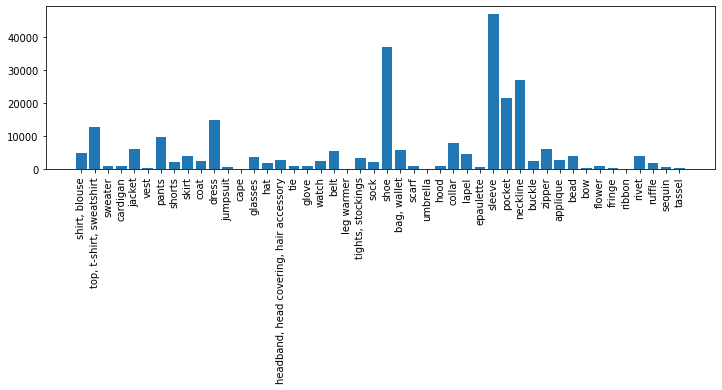

Total validation images:  9039
Total validation segments:  66264


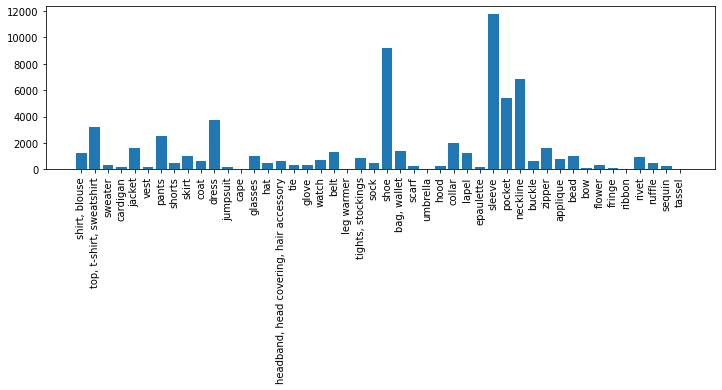

In [28]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

**Building attribute detection model**

In [29]:
def make_mask(data):
    df = data.reset_index(drop = True)
    H = df.iloc[0,2]
    W = df.iloc[0,3]
    
#     print("Correct Category :", int(df.CategoryId))
    # 1d mask 
    mask = np.full(H*W,dtype='int',fill_value = -1)
    
    for line in df[['EncodedPixels','CategoryId']].iterrows():
        # 1d mask 
#         mask = np.full(H*W,dtype='int',fill_value = -1)
        
        EncodedPixels = line[1][0]
        Category = line[1][1]
        print(Category)
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = Category
        mask = mask.reshape(W,H).T
    return mask

In [30]:
IMAGE_SIZE2 = 299

In [31]:
img_id_list, apparel_img_list, cat_list, att_list = [], [], [],[]
apparel_id_list, att_id_list = [], []
# for i in range(seg_att_df.shape[0]):
for i in range(100):
#     if i%100==0:
#     print(i)
    img_id_list+=[seg_att_df['ImageId'][i]]
    mask1 = make_mask(seg_att_df.iloc[i:i+1])
    mask1 = cv2.resize(mask1, (IMAGE_SIZE2, IMAGE_SIZE2), interpolation=cv2.INTER_NEAREST)  
    apparel_img_list+=[mask1]
    apparel_id_list+=[int(seg_att_df['CategoryId'][i])]
    cat_list+=[label_names[int(seg_att_df['CategoryId'][i])]]
    att_id_list+=[seg_att_df['AttributeId'][i]]
    att_list+=[[attribute_names[int(x)] for x in seg_att_df['AttributeId'][i]]]
    # print(att_list,apparel_id_list )
image_att = pd.DataFrame({'ImageId':img_id_list,'ApparelImage':apparel_img_list,'ApparelId': apparel_id_list, 
                          'ApparelClass':cat_list,'AttributeId':att_id_list,'AttributeType':att_list})

10
3
10
4
6
4
10
10
1
7
1
8
8
4
1
8
6
1
4
10
10
1
6
9
10
1
4
6
10
9
4
9
1
6
1
5
7
10
10
10
1
10
4
6
1
0
10
4
6
10
10
10
8
1
10
10
1
4
6
1
6
4
10
1
1
4
6
10
10
10
0
10
1
6
1
6
1
7
10
1
6
8
1
10
1
7
10
1
4
6
10
9
10
6
10
10
7
1
10
10


In [32]:
image_att

,ImageId,ApparelImage,ApparelId,ApparelClass,AttributeId,AttributeType
0,000aac3870ea7c59ca0333ffa5327323.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",10,dress,"[3, 20, 34, 56, 69, 91]","[mini (length), symmetrical, a-line, cutout, f..."
1,000aac3870ea7c59ca0333ffa5327323.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",3,cardigan,"[1, 10, 20, 41, 60, 61, 91]","[hip (length), single breasted, symmetrical, r..."
2,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",10,dress,"[5, 19, 33, 59, 61, 66, 88]","[knee (length), asymmetrical, straight, lining..."
3,000e973c99dc090afd7898c93daf0dbc.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",4,jacket,"[0, 20, 41, 60, 72, 88]","[above-the-hip (length), symmetrical, regular ..."
4,000e973c99dc090afd7898c93daf0dbc.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",6,pants,"[8, 20, 39, 60, 70]","[maxi (length), symmetrical, curved (fit), no ..."
...,...,...,...,...,...,...
95,023f2eb91095b865fc204ad80c516b77.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",10,dress,"[2, 14, 20, 34, 52, 61, 91]","[micro (length), zip-up, symmetrical, a-line, ..."
96,024767e511bcc50af134f7b545210e44.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",7,shorts,"[2, 20, 41, 48, 61]","[micro (length), symmetrical, regular (fit), f..."
97,024767e511bcc50af134f7b545210e44.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",1,"top, t-shirt, sweatshirt","[20, 41, 61, 91]","[symmetrical, regular (fit), plain (pattern), ..."
98,0248ac2a108ee8c57c5ad931631ef886.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",10,dress,"[9, 14, 20, 38, 57, 61, 86]","[floor (length), zip-up, symmetrical, high low..."


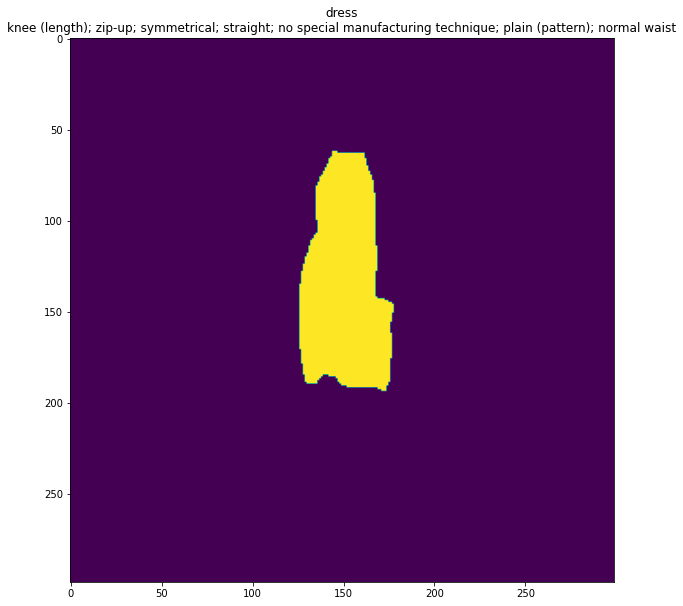

In [33]:
# for i in range(len(image_att)):
for i in range(1):
    plt.figure(figsize=[10,10])
    choice = random.randint(1, 99)
    # print(image_att['ApparelImage'][choice])
    plt.imshow(image_att['ApparelImage'][choice])
    plt.title(image_att['ApparelClass'][choice]+'\n'+'; '.join(image_att['AttributeType'][choice]))

In [34]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Dense,BatchNormalization,Dropout,Embedding,RepeatVector
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.models import Model
from pickle import dump, load
from keras.models import load_model
import numpy as np
inception = InceptionV3(weights='imagenet')

# pop the last softmax layer and freezing the remaining layers (re-structure the model)
inception.layers.pop()
#
for layer in inception.layers:
    layer.trainable = False

# building the final model
pre_trained_incept_v3 = Model(input = inception.input,output = inception.layers[-1].output)

In [35]:
pre_trained_incept_v3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [36]:
msk = np.random.rand(len(image_att)) <= 0.8
train_att = image_att[msk].reset_index(drop=True)
val_att = image_att[~msk].reset_index(drop=True)

In [37]:
print(train_att.shape)
print(val_att.shape)

(79, 6)
(21, 6)


In [38]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Dense,BatchNormalization,Dropout,Embedding,RepeatVector
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

TARGET_SIZE = (299,299) # needed to convert the image as per pre-trained inceptionv3 requirements

img_feat_list = []
for i in range(len(train_att)):
    img = image_att['ApparelImage'][i]
    img = np.stack((img,)*3, axis=-1) # creating gray scale to 3-channel image
    # Converting image to array
    img_array = img_to_array(img)
    nimage = preprocess_input(img_array)
    # Adding one more dimesion
    nimage = np.expand_dims(nimage, axis=0)    
    fea_vec = pre_trained_incept_v3.predict(nimage)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    img_feat_list+=[fea_vec]
train_att['img_feat'] = img_feat_list

In [39]:
train_att['AttributeType'][0]

['mini (length)', 'symmetrical', 'a-line', 'cutout', 'floral', 'no waistline']

Total Apparel images:  79
All atributes throughout apparel images:  657


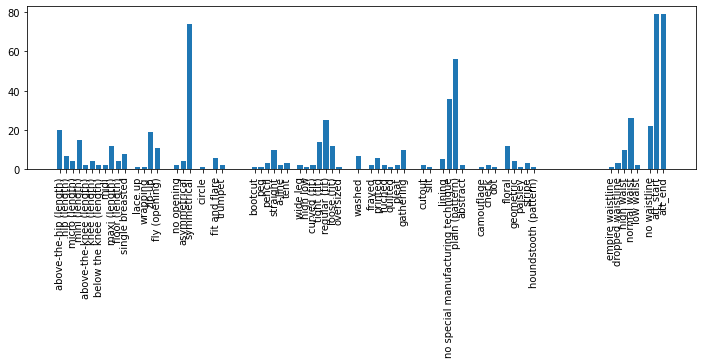

Max. number of attributes: 11
Feature vocab size: 50


In [40]:
from keras.preprocessing.text import Tokenizer
# as we'll be building it as image captioning model, we need to add some fixed start and end attributes"
train_att['AttributeId'] = [[92]+x+[93] for x in train_att['AttributeId']]
train_att['AttributeType'] = [['att_start']+x+['att_end'] for x in train_att['AttributeType']]

total_train_att = np.concatenate(train_att['AttributeId'].values).astype(int)
print("Total Apparel images: ", len(train_att))
print("All atributes throughout apparel images: ", len(total_train_att))

attribute_names+=['att_start','att_end']

plt.figure(figsize=(12, 3))
values, counts = np.unique(total_train_att, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, [attribute_names[x] for x in values], rotation='vertical')
plt.show()

#currently, dropping apparel attributes with freq. < 10
final_val = values[counts>=2]
final_att = [attribute_names[x] for x in final_val]

train_att['Final_att'] = [[x for x in z if x in final_att] for z in train_att['AttributeType']]

max_no = max([len(x) for x in train_att['Final_att']])
print('Max. number of attributes:', max_no)
vocab_size = len(final_att) + 1
print('Feature vocab size:', vocab_size)

ixtoword = {}
wordtoix = {}

ix = 1
for w in final_att:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
# token = Tokenizer(num_words=vocab_size)
# token.fit_on_texts(final_att)

In [41]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in final_att:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [42]:
wordtoix

{'a-line': 21,
 'above-the-hip (length)': 1,
 'above-the-knee (length)': 5,
 'abstract': 38,
 'asymmetrical': 15,
 'att_end': 49,
 'att_start': 48,
 'below the knee (length)': 7,
 'check': 39,
 'curved (fit)': 24,
 'cutout': 34,
 'dropped waistline': 43,
 'fit and flare': 17,
 'floor (length)': 10,
 'floral': 40,
 'fly (opening)': 13,
 'frayed': 29,
 'gathering': 33,
 'geometric': 41,
 'high waist': 44,
 'hip (length)': 2,
 'knee (length)': 6,
 'lining': 35,
 'loose (fit)': 27,
 'low waist': 46,
 'maxi (length)': 9,
 'micro (length)': 3,
 'midi': 8,
 'mini (length)': 4,
 'no opening': 14,
 'no special manufacturing technique': 36,
 'no waistline': 47,
 'normal waist': 45,
 'pencil': 19,
 'plain (pattern)': 37,
 'pleat': 32,
 'printed': 30,
 'regular (fit)': 26,
 'ruched': 31,
 'single breasted': 11,
 'straight': 20,
 'stripe': 42,
 'symmetrical': 16,
 'tent': 22,
 'tight (fit)': 25,
 'trumpet': 18,
 'washed': 28,
 'wide leg': 23,
 'zip-up': 12}

In [43]:
train_att.head()

,ImageId,ApparelImage,ApparelId,ApparelClass,AttributeId,AttributeType,img_feat,Final_att
0,000aac3870ea7c59ca0333ffa5327323.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",10,dress,"[92, 3, 20, 34, 56, 69, 91, 93]","[att_start, mini (length), symmetrical, a-line...","[0.03138652, 0.20766674, 0.07411595, 0.4187253...","[att_start, mini (length), symmetrical, a-line..."
1,000aac3870ea7c59ca0333ffa5327323.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",3,cardigan,"[92, 1, 10, 20, 41, 60, 61, 91, 93]","[att_start, hip (length), single breasted, sym...","[0.20307113, 0.55998826, 0.18413937, 0.5850497...","[att_start, hip (length), single breasted, sym..."
2,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",10,dress,"[92, 5, 19, 33, 59, 61, 66, 88, 93]","[att_start, knee (length), asymmetrical, strai...","[0.29003143, 0.5768428, 0.15959099, 0.25654358...","[att_start, knee (length), asymmetrical, strai..."
3,000e973c99dc090afd7898c93daf0dbc.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",4,jacket,"[92, 0, 20, 41, 60, 72, 88, 93]","[att_start, above-the-hip (length), symmetrica...","[0.22779159, 0.13957888, 0.17129903, 0.2667508...","[att_start, above-the-hip (length), symmetrica..."
4,000e973c99dc090afd7898c93daf0dbc.jpg,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",6,pants,"[92, 8, 20, 39, 60, 70, 93]","[att_start, maxi (length), symmetrical, curved...","[0.20398371, 0.55236214, 0.22271036, 0.4849080...","[att_start, maxi (length), symmetrical, curved..."


**Defining encoder-decoder model**

In [44]:
from keras.models import Model,Input
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import Embedding,Dense,BatchNormalization,Dropout,LSTM,add
from keras.utils import plot_model

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np

def combined_model(MAX_LENGTH,VOCAB_SIZE):
    "model parameters"
#    NPIX = 299 # required image shape for pre-trained inceptionnv3 model 
#    TARGET_SIZE = (NPIX,NPIX,3)
    EMBEDDING_SIZE = 256 #
    
    # partial caption sequence model    
    inputs2 = Input(shape=(MAX_LENGTH,))
    se1 = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(EMBEDDING_SIZE)(se2) 
    
    
    # image feature extractor model
    inputs1 = Input(shape=(2048,)) # iceptionnv3
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(EMBEDDING_SIZE, activation='relu')(fe1)
    
    
    
    decoder1 = add([fe2, se3])
    decoder2 = Dense(EMBEDDING_SIZE, activation='relu')(decoder1) 
    #decoder2 = Dense(50, activation='relu')(decoder1) 
    outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)
    
    
    # merge the two input models
    # image_feature + partial caption ===> output
    model = Model(inputs=[inputs1, inputs2], outputs=outputs) 
    
    # setting wight of embedded matrix that we saved earlier for words
#     with open("embedding_matrix.pkl","rb") as f:
#         embedding_matrix = load(f)   
#     model.layers[2].set_weights([embedding_matrix])
#     model.layers[2].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

def data_generator(train_att, MAX_LENGTH,VOCAB_SIZE, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    for i in range(len(train_att)):
        n+=1
        photo = train_att['img_feat'][i]
        att_list = list(train_att['Final_att'][i])
        
        seq = [wordtoix[x] for x in att_list]
        for i in range(1,len(seq)):
            in_seq , op_seq = seq[:i],seq[i]
            #converting input sequence to fix length
            in_seq = pad_sequences([in_seq],maxlen=MAX_LENGTH,padding="post")[0]
            # converting op_seq to vocabulary size
#                    print(op_seq)
            op_seq = to_categorical([op_seq],num_classes=VOCAB_SIZE)[0]
#                    try:
#                        op_seq = to_categorical([op_seq],num_classes=VOCAB_SIZE)[0]
#                    except:
#                        op_seq = np.array([0]*VOCAB_SIZE)
            X1.append(photo)
            X2.append(in_seq)
            y.append(op_seq)
        # yield the batch data
        if n==num_photos_per_batch:
            yield [[np.array(X1), np.array(X2)], np.array(y)]
            X1, X2, y = list(), list(), list()
            n=0

max_length = 200
# image feature extracted file
train_image_extracted = train_att['img_feat']

#"load train attributes
train_descriptions = train_att['Final_att']


model = combined_model(max_length, vocab_size) #

epochs = 10


len(train_descriptions)


for i in range(epochs):
    batch_size = number_pics_per_batch = 5
    steps = len(train_descriptions)//number_pics_per_batch
    generator = data_generator(train_att,max_length, vocab_size,number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

att_prediction_model = model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Epoch 1/1
15/15 [==============================] - 16s 1s/step - loss: 3.5034
Epoch 1/1
15/15 [==============================] - 14s 943ms/step - loss: 3.0570
Epoch 1/1
15/15 [==============================] - 15s 1s/step - loss: 2.5956
Epoch 1/1
15/15 [==============================] - 14s 946ms/step - loss: 2.2819
Epoch 1/1
15/15 [==============================] - 14s 935ms/step - loss: 1.9910
Epoch 1/1
15/15 [==============================] - 14s 943ms/step - loss: 1.7545
Epoch 1/1
15/15 [==============================] - 14s 932ms/step - loss: 1.5408
Epoch 1/1
15/15 [==================

In [45]:
def new_make_mask(img):
    H = img.shape[0]
    W = img.shape[1]
    # 1d mask 
    mask = np.full(H*W,dtype='int',fill_value = -1)
    mask = mask.reshape(W,H).T
#    black = np.array([0,0,0])
    # print(type(black))
    # print(type(img[0][0][0]))
    # print()
#    for row in range(H):
#    for colm in range(W):
#    		if not np.allclose(black,img[row][colm]):
#    			mask[row][colm] = 10
#    

    indices_list = np.where(np.any(img != 0, axis = -1))
    mask[indices_list] = 10 
    mask = cv2.resize(mask, (299, 299), interpolation=cv2.INTER_NEAREST)
    plt.imshow(mask)
    return mask

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

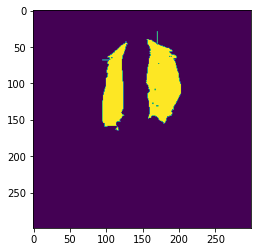

In [46]:
img = cv2.imread("/content/drive/My Drive/grabcutt/2020031900h41m08s.jpg.png")
new_make_mask(img)

In [47]:

# extract features from each photo in the directory
def extract_features(img):
    img = np.stack((img,)*3, axis=-1) # creating gray scale to 3-channel image
    # Converting image to array
    img_array = img_to_array(img)
    nimage = preprocess_input(img_array)
    # Adding one more dimesion
    nimage = np.expand_dims(nimage, axis=0)    
    fea_vec = pre_trained_incept_v3.predict(nimage)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


# generate a description for an image
def generate_desc(model, photo, max_length):
    # seed the generation process
    sequence = ['att_start']
    photo = photo.reshape(1,2048)

    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        seq = [wordtoix[x] for x in sequence]
        # pad input
        seq1 = pad_sequences([seq], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,seq1], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        sequence+=[word]
        # stop if we predict the end of the sequence
        if word == 'att_end':
            break
    return sequence
        
 

"prediction on new images"
val_att = train_att.copy()




In [48]:
masked_images = os.listdir("/content/drive/My Drive/Final_masks")[:-1]
print(masked_images)

['2020102213h37m13s.png', '2020102211h48m23s.png', '2020102120h05m21s.png', '2020102117h44m33s.png', '2020102110h22m46s.png', '2020102018h59m23s.png', '2020102014h50m35s.png', '2020102011h11m04s.png', '2020101921h11m44s.png', '2020101916h18m44s.png', '2020101900h38m57s.png', '2020101818h39m41s.png', '2020101818h32m08s.png', '2020101816h49m38s.png', '2020101816h48m47s.png', '2020101621h17m05s.png', '2020101620h40m26s.png', '2020101516h31m16s.png', '2020101515h30m49s.png', '2020101510h56m53s.png', '2020101500h23m59s.png', '2020101418h46m07s.png', '2020101417h08m06s.png', '2020101317h49m23s.png', '2020101220h40m33s.png', '2020101218h56m53s.png', '2020101213h24m04s.png', '2020101123h20m13s.png', '2020101118h38m53s.png', '2020101116h16m20s.png', '2020101101h15m53s.png', '2020101011h22m37s.png', '2020101011h14m01s.png', '2020101002h28m07s.png', '2020100920h36m40s.png', '2020100918h32m04s.png', '2020100821h30m14s.png', '2020100817h4228s.png', '2020100816h5039s.png', '20201030 18h09m53s.jpg', 

In [49]:
os.chdir("/content/drive/My Drive/Final_masks")
!ls

 2020031900h41m08s.png	 2020101500h23m59s.png	  '20201028 20h11m46s.png'
 2020031918h58m24s.png	 2020101510h56m53s.png	  '20201028 20h27m50s.png'
 2020032001h02m42s.png	 2020101515h30m49s.png	  '20201028 21h32m03s.png'
 2020093016h48m18s.png	 2020101516h31m16s.png	  '20201029 01h47m12s.png'
 2020093017h16m02s.png	 2020101520h33m09s.png	  '20201029 03h39m07s.png'
 2020093018h00m13s.png	 2020101617h06m27s.png	  '20201029 05h19m25s.png'
 2020093021h39m49s.png	 2020101620h40m26s.png	  '20201029 13h34m58s.png'
 2020100107h22m02s.png	 2020101621h17m05s.png	  '20201029 15h24m31s.png'
 2020100113h53m29s.png	 2020101718h17m32s.png	  '20201029 16h10m11s.png'
 2020100114h43m03s.png	 2020101718h32m07s.png	  '20201029 17h46m07s.png'
 2020100115h49m17s.png	 2020101816h09m28s.png	  '20201029 18h19m25s.png'
 2020100116h33m09s.png	 2020101816h48m47s.png	  '20201029 18h43m57s.png'
 2020100116h42m54s.png	 2020101816h49m38s.png	  '20201029 19h20m52s.png'
 2020100116h43m38s.png	 2020101818h32m08s.png	  '20

In [50]:
def get_image_id(mask):
  # id = mask[0:8]
  # id = id + mask[8:-4]
  mask = mask[:-4]
  mask = mask + ".jpg"
  mask = mask.replace(" ","")
  return mask

In [51]:
print(get_image_id("20200930 17h16m02s.png"))

2020093017h16m02s.jpg


***FINAL ATTRIBUTES***

In [52]:
masked_images = masked_images[:-1]
print(len(masked_images))

130


1
2020102213h37m13s.png
['symmetrical', 'straight', 'pencil', 'plain (pattern)', 'normal waist']
2
2020102211h48m23s.png
['symmetrical', 'pencil', 'no special manufacturing technique', 'plain (pattern)', 'high waist']
3
2020102120h05m21s.png
['symmetrical', 'straight', 'straight', 'no special manufacturing technique', 'plain (pattern)', 'high waist']
4
2020102117h44m33s.png
['symmetrical', 'tight (fit)', 'no special manufacturing technique', 'plain (pattern)', 'no waistline']
5
2020102110h22m46s.png
['symmetrical', 'symmetrical', 'straight', 'plain (pattern)', 'normal waist']
6
2020102018h59m23s.png
['symmetrical', 'tight (fit)', 'no special manufacturing technique', 'plain (pattern)', 'normal waist']
7
2020102014h50m35s.png
['symmetrical', 'symmetrical', 'no special manufacturing technique', 'plain (pattern)', 'high waist']
8
2020102011h11m04s.png
['symmetrical', 'pencil', 'no special manufacturing technique', 'plain (pattern)', 'high waist']
9
2020101921h11m44s.png
['symmetrical', 't

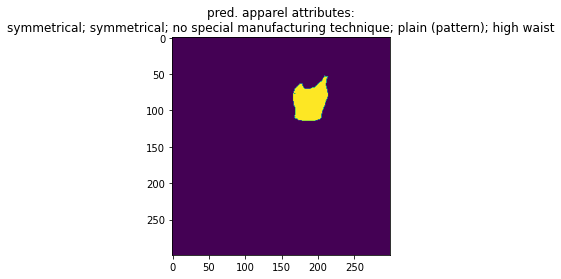

In [53]:
att_list = []
img_id = []
count = 1
for mask in masked_images:
  print(count)
  count += 1
  print(mask)
  temp = []
  temp.append(get_image_id(mask))
  img_id.append(temp)
  f1 = cv2.imread(mask)
  img = new_make_mask(f1)
  plt.imshow(img)
  photo = extract_features(img)
  description = generate_desc(att_prediction_model, photo, max_length)
  pred_att = [x for x in description if x not in ['att_start', 'att_end']]
  print(pred_att)
  att_list.append(pred_att)
  plt.title('pred. apparel attributes:\n'+'; '.join(pred_att))

***SAVE IN CSV***

In [54]:
print(len(att_list))
import csv
with open("/content/drive/My Drive/db/attributes.csv", "w", newline="") as f:
   writer = csv.writer(f)
   writer.writerows(att_list)

print(len(img_id))
with open("/content/drive/My Drive/db/img_id.csv", "w", newline="") as f:
   writer = csv.writer(f)
   writer.writerows(img_id)

130
130


In [55]:
def random_colors(N):
    np.random.seed(1) # to make sure colors are consistent everytime
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

In [56]:
def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 255,
            150,
            image[:, :, n]
        )
#     image[mask==255] = (0,0,255)
    return image

In [57]:
def display_instances(image, mask):
    """
        take the image and results and apply the mask, box, and Label
    """
#     n_instances = boxes.shape[0]
    colors = random_colors(3)

#     if not n_instances:
#         print('NO INSTANCES TO DISPLAY')
#     else:
#         assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
#         if not np.any(boxes[i]):
#             continue

#         y1, x1, y2, x2 = boxes[i]
#         label = names[ids[i]]
#         score = scores[i] if scores is not None else None
#         caption = '{} {:.2f}'.format(label, score) if score else label
#         mask = masks[:, :, i]
#         masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
#             for m in range(r['masks'].shape[-1]):
        mask = cv2.resize(mask.astype('uint8'),(image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        plt.imshow(mask)
#         for row in mask:
#             for colm in row:
#                 if colm is not 255:
#                     print(colm)
#         print(image)
        image = apply_mask(image, mask, color)
#         image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
#         image = cv2.putText(
#             image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
#         )

    return image

**COLOR DETECTION**

In [58]:
!pip install webcolors

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
import webcolors

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    counts_new = [i for i in range(0, len(counts)-1)]
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i].tolist() for i in counts.keys()]
    hex_colors.pop(0)
    rgb_colors.pop(0)
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts_new, labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

def closest_colour(requested_colour):
    min_colours = {}
    color_dict = webcolors.CSS3_NAMES_TO_HEX
    print(color_dict)
    color_dict['brown'] = '#a52a2a'
    color_dict['pink'] = '#dda0dd'
    for name, key in webcolors.CSS3_NAMES_TO_HEX.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name


In [60]:
def get_closest_color(color_name):
  color_dict = {
      "ebony" : "black",
      "taupe" : "black",
      "charcoal" : "black",
      "outer_space" : "black",
      "oynx" : "black",
      "jet" : "black",
      "licorice" : "black",
      "arsenic" : "grey",
      "gray":"grey"
  }

  primary_colors = ["red", "green", "blue", "black", "grey", "pink", "yellow", "white", "brown", "orange", "purple", "violet", "Cyan", "silver", "maroon", "navy", "teal"]

  color_name = color_name.lower()
  if color_name in color_dict.keys():
    color_name = color_dict[color_name]

  colors = []
  for color in primary_colors:
    if color in color_name:
      colors.append(color)

  return colors

In [62]:
color_file = "/content/drive/My Drive/color_list.csv"
index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv(color_file, names=index, header=None)

def getColorName(color):
    R = color[0]
    G = color[1]
    B = color[2]
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G-int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

In [63]:
print(getColorName([255, 0, 0]))

Red


In [64]:
colors = []
for name, key in webcolors.CSS3_NAMES_TO_HEX.items():
  colors.append(name)
print(colors)

['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgrey', 'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen', 

In [65]:
print(get_colour_name([212.71339375628312, 178.27371601207335, 221.6467270896092])[1])
#(255,192,203)
#(192,192,192)

{'aliceblue': '#f0f8ff', 'antiquewhite': '#faebd7', 'aqua': '#00ffff', 'aquamarine': '#7fffd4', 'azure': '#f0ffff', 'beige': '#f5f5dc', 'bisque': '#ffe4c4', 'black': '#000000', 'blanchedalmond': '#ffebcd', 'blue': '#0000ff', 'blueviolet': '#8a2be2', 'brown': '#a52a2a', 'burlywood': '#deb887', 'cadetblue': '#5f9ea0', 'chartreuse': '#7fff00', 'chocolate': '#d2691e', 'coral': '#ff7f50', 'cornflowerblue': '#6495ed', 'cornsilk': '#fff8dc', 'crimson': '#dc143c', 'cyan': '#00ffff', 'darkblue': '#00008b', 'darkcyan': '#008b8b', 'darkgoldenrod': '#b8860b', 'darkgray': '#a9a9a9', 'darkgrey': '#a9a9a9', 'darkgreen': '#006400', 'darkkhaki': '#bdb76b', 'darkmagenta': '#8b008b', 'darkolivegreen': '#556b2f', 'darkorange': '#ff8c00', 'darkorchid': '#9932cc', 'darkred': '#8b0000', 'darksalmon': '#e9967a', 'darkseagreen': '#8fbc8f', 'darkslateblue': '#483d8b', 'darkslategray': '#2f4f4f', 'darkslategrey': '#2f4f4f', 'darkturquoise': '#00ced1', 'darkviolet': '#9400d3', 'deeppink': '#ff1493', 'deepskyblue'

In [66]:
MASK_DIR = "/content/drive/My Drive/Final_masks"

In [67]:
# os.chdir(MASK_DIR)
# !ls
# masked_img_list = os.listdir(MASK_DIR)
# print(masked_img_list) 

130
2020102213h37m13s.png 1
['black', 'green']
2020102211h48m23s.png 2
['black', 'green', 'brown']
2020102120h05m21s.png 3
['grey', 'black']
2020102117h44m33s.png 4
['grey', 'red']
2020102110h22m46s.png 5
['green']
2020102018h59m23s.png 6
['black', 'pink', 'brown']
2020102014h50m35s.png 7
['grey', 'blue', 'red', 'green']
2020102011h11m04s.png 8
['brown']
2020101921h11m44s.png 9
['grey', 'silver']
2020101916h18m44s.png 10
['grey', 'black']
2020101900h38m57s.png 11
['maroon', 'brown']
2020101818h39m41s.png 12
['grey', 'black', 'green']
2020101818h32m08s.png 13
['grey', 'blue']
2020101816h49m38s.png 14
['grey', 'blue']
2020101816h48m47s.png 15
['grey', 'blue', 'black']
2020101621h17m05s.png 16
['pink']
2020101620h40m26s.png 17
['black', 'green']
2020101516h31m16s.png 18
['black', 'red', 'silver', 'brown']
2020101515h30m49s.png 19
['white', 'black', 'grey']
2020101510h56m53s.png 20
['black', 'brown']
2020101500h23m59s.png 21
['orange', 'brown']
2020101418h46m07s.png 22
['grey', 'black', 'g

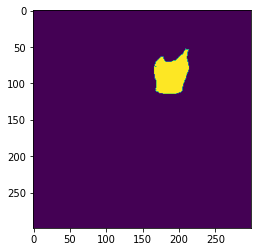

In [68]:
color_list = []
count = 1
print(len(masked_images))
for mask in masked_images:
  color = random_colors(3)
  print(mask, count)
  count += 1
  image = cv2.imread(os.path.join(MASK_DIR,mask))
  mask = new_make_mask(image)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #plt.imshow(image)

  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #plt.imshow(gray_image, cmap='gray')

  resized_image = cv2.resize(image, (1200, 600))
  #plt.imshow(resized_image)

  rgb = get_colors(image, 8, False)
#  print(rgb)
  colors = []
  for color in rgb:
    name = getColorName(color)
    names = []
    for j in name.split(" "):
      names.append(j)
    for j in name.split("_"):
      names.append(j)

    for name in names:
      temp = get_closest_color(name)
      for i in temp:
        colors.append(i)

  colors = list(set(colors))

  if len(colors) is not 0:
    color_list.append(colors)
  else:
    color_list.append(-1)
  print(colors)



In [69]:
print(color_list)
for row in range(len(color_list)):
  if color_list[row] == -1:
    color_list[row] = ['1']
import csv
with open("/content/drive/My Drive/db/colors.csv", "w", newline="") as f:
   writer = csv.writer(f)
   writer.writerows(color_list)

print(len(color_list))

[['black', 'green'], ['black', 'green', 'brown'], ['grey', 'black'], ['grey', 'red'], ['green'], ['black', 'pink', 'brown'], ['grey', 'blue', 'red', 'green'], ['brown'], ['grey', 'silver'], ['grey', 'black'], ['maroon', 'brown'], ['grey', 'black', 'green'], ['grey', 'blue'], ['grey', 'blue'], ['grey', 'blue', 'black'], ['pink'], ['black', 'green'], ['black', 'red', 'silver', 'brown'], ['white', 'black', 'grey'], ['black', 'brown'], ['orange', 'brown'], ['grey', 'black', 'green'], ['grey', 'black', 'silver', 'brown'], ['black', 'brown'], ['black', 'silver'], ['grey', 'black', 'green'], ['grey', 'black', 'purple'], ['maroon', 'brown'], ['grey', 'black', 'green'], ['grey', 'black', 'green'], ['grey', 'black', 'green'], ['grey', 'silver'], ['grey', 'blue'], ['black', 'green'], ['grey', 'black', 'brown'], ['grey', 'black', 'green'], ['black', 'pink', 'brown'], ['grey', 'black', 'blue'], ['black', 'green'], ['grey', 'black', 'white'], ['red', 'brown'], ['grey', 'black'], ['grey', 'black', 'g